# Варианты детекции изменений тренда

In [1]:
# %conda install ruptures wotan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pmd
import ruptures as rpt
import scipy
import statsmodels.api as sm
from matplotlib import rcParams
from sklearn import linear_model
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from wotan import flatten

## Use wotan to detrend data

In [2]:
data = sm.datasets.get_rdataset('co2')
data = data.data

data['time_pd'] = pd.to_datetime('1959-01-01') + pd.to_timedelta((data.time - 1959 )* 365, unit='D') - pd.Timedelta(days=1)
data = data.set_index('time')

Run wotan:

In [3]:
flatten_lc, trend_lc = flatten(
    data.index,                 # Array of time values
    data.value,                 # Array of flux values
    method='biweight',
    window_length=4,    # The length of the filter window in units of ``time``
    edge_cutoff=0.5,      # length (in units of time) to be cut off each edge.
    break_tolerance=0.5,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    cval=5.0              # Tuning parameter for the robust estimators
    )

Visualize the result:

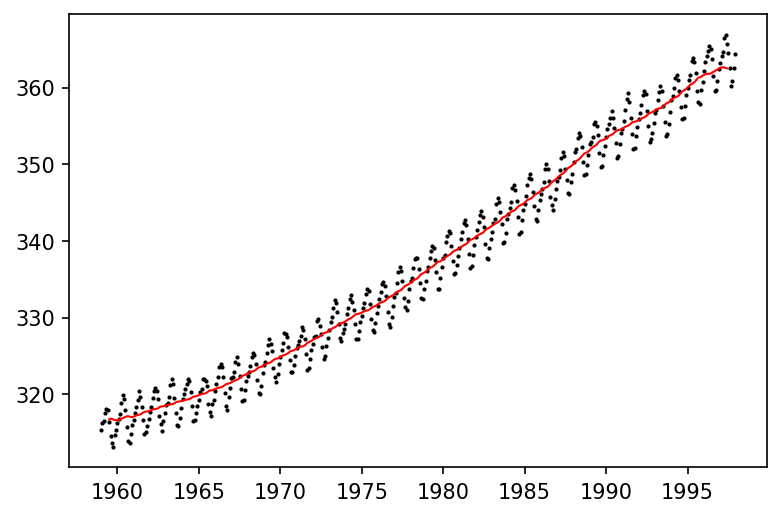

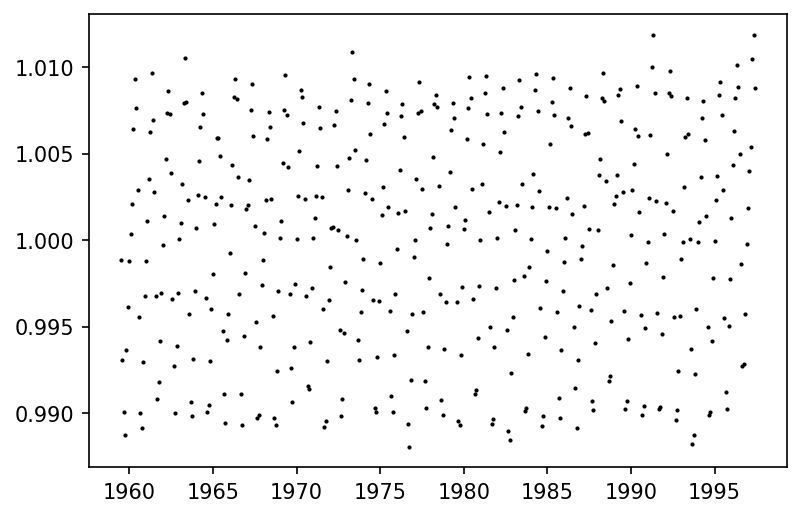

In [4]:
rcParams["figure.dpi"] = 150

plt.scatter(data.index, data.value, s=1, color='black')
plt.plot(data.index, trend_lc, color='red', linewidth=1)
plt.show();
plt.close()

plt.scatter(data.index, flatten_lc, s=1, color='black');

## use ruptures to detect changepoints in trend

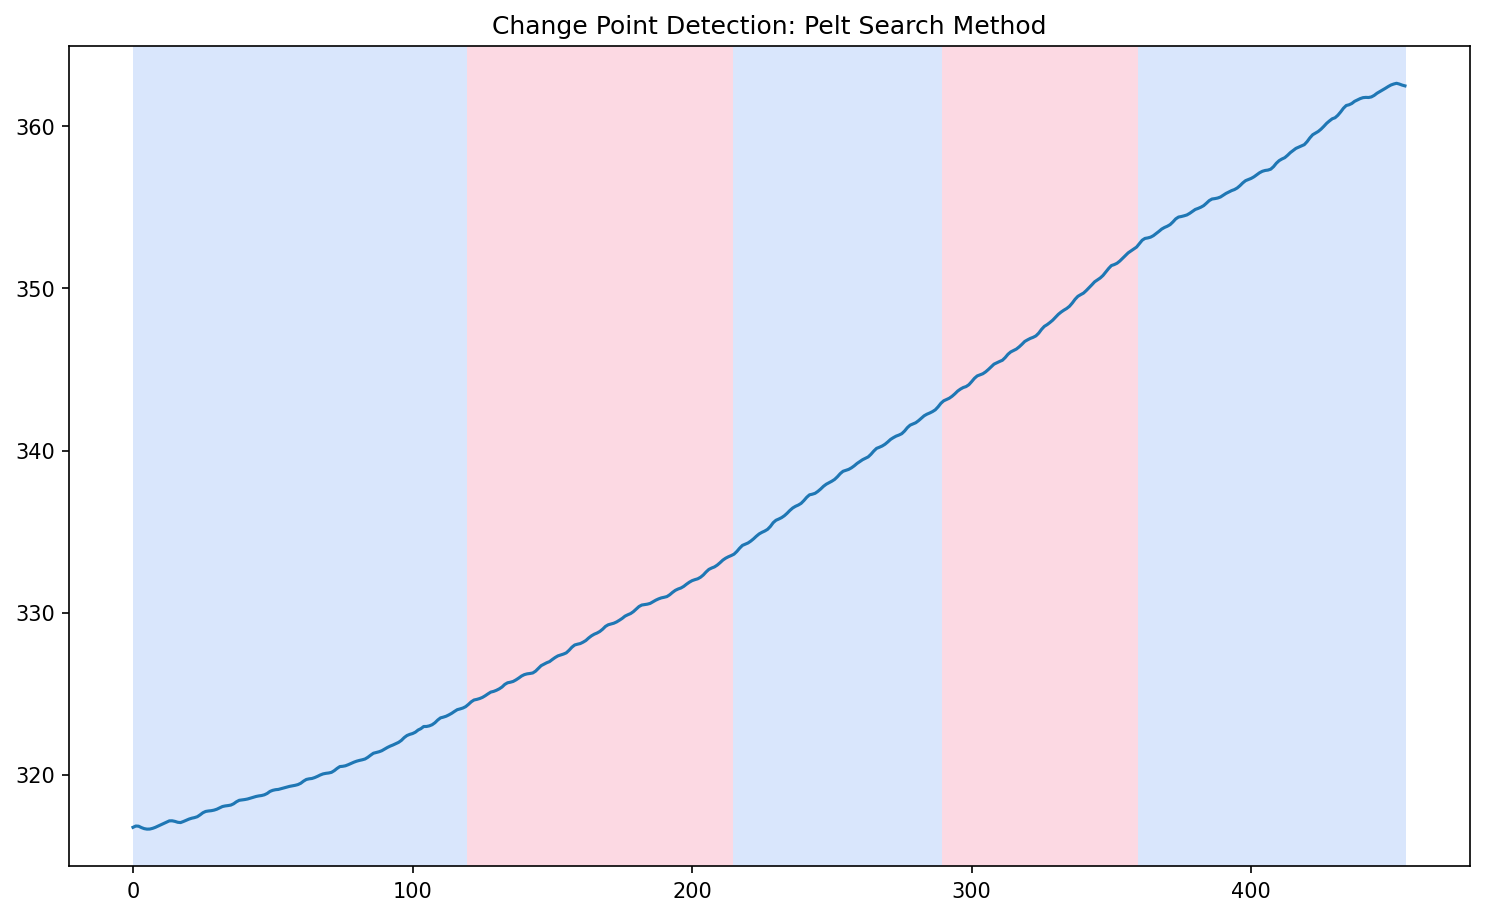

In [5]:
only_trenc = pd.DataFrame(trend_lc).dropna()
model="rbf"
algo = rpt.Pelt(model=model).fit(only_trenc)
result = algo.predict(pen=10)
rpt.display(only_trenc, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  

## Use ttest to detect delta in forecast vs real and substitute trend

### EDA

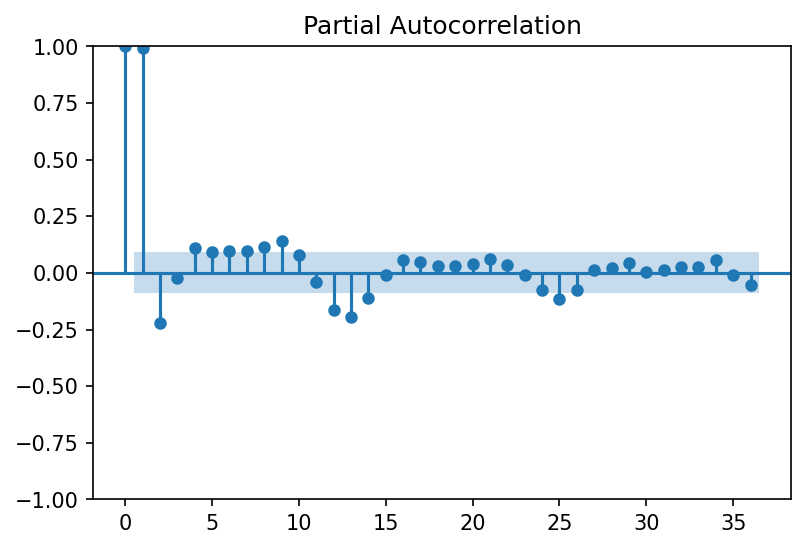

In [6]:
sm.graphics.tsa.plot_pacf(data.value, lags=36, method="ywm")
plt.show()

In [7]:
X_train = data[data.index< 1990]
X_test = data[data.index>= 1990]

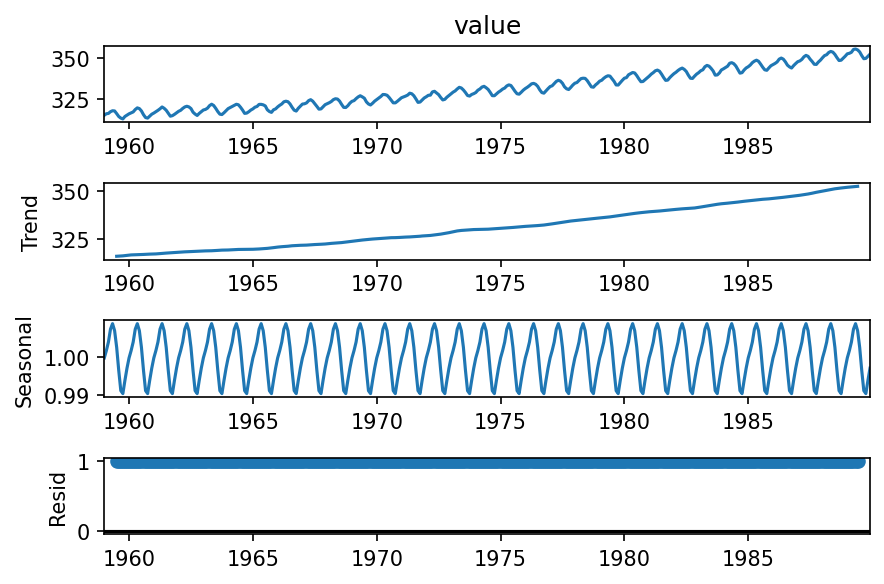

In [8]:
decomposed = sm.tsa.seasonal_decompose(X_train.value, model='multiplicative', period=12)
decomposed.plot()
plt.show()

In [9]:
X_train=X_train.set_index('time_pd')
X_train.index = X_train.index.to_period('M')

X_test=X_test.set_index('time_pd')
X_test.index = X_test.index.to_period('M')

In [10]:
pmd.arima.ndiffs(X_train.value)

1

In [11]:
pmd.arima.nsdiffs(X_train.value, 12)

1

In [12]:
mod = sm.tsa.statespace.SARIMAX(X_train.value,
                                order=(1, 1, 0),
                                seasonal_order=(2, 1, 0, 12))
fit_mod = mod.fit()
fit_mod.summary().tables[1]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79801D-01    |proj g|=  7.86770D-01

At iterate    5    f=  2.51465D-01    |proj g|=  9.84488D-03


 This problem is unconstrained.



At iterate   10    f=  2.51346D-01    |proj g|=  6.67097D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   6.486D-05   2.513D-01
  F =  0.25134601427976960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3160,0.047,-6.745,0.000,-0.408,-0.224
ar.S.L12,-0.6162,0.048,-12.708,0.000,-0.711,-0.521
ar.S.L24,-0.3519,0.050,-7.013,0.000,-0.450,-0.254
sigma2,0.0969,0.008,12.454,0.000,0.082,0.112


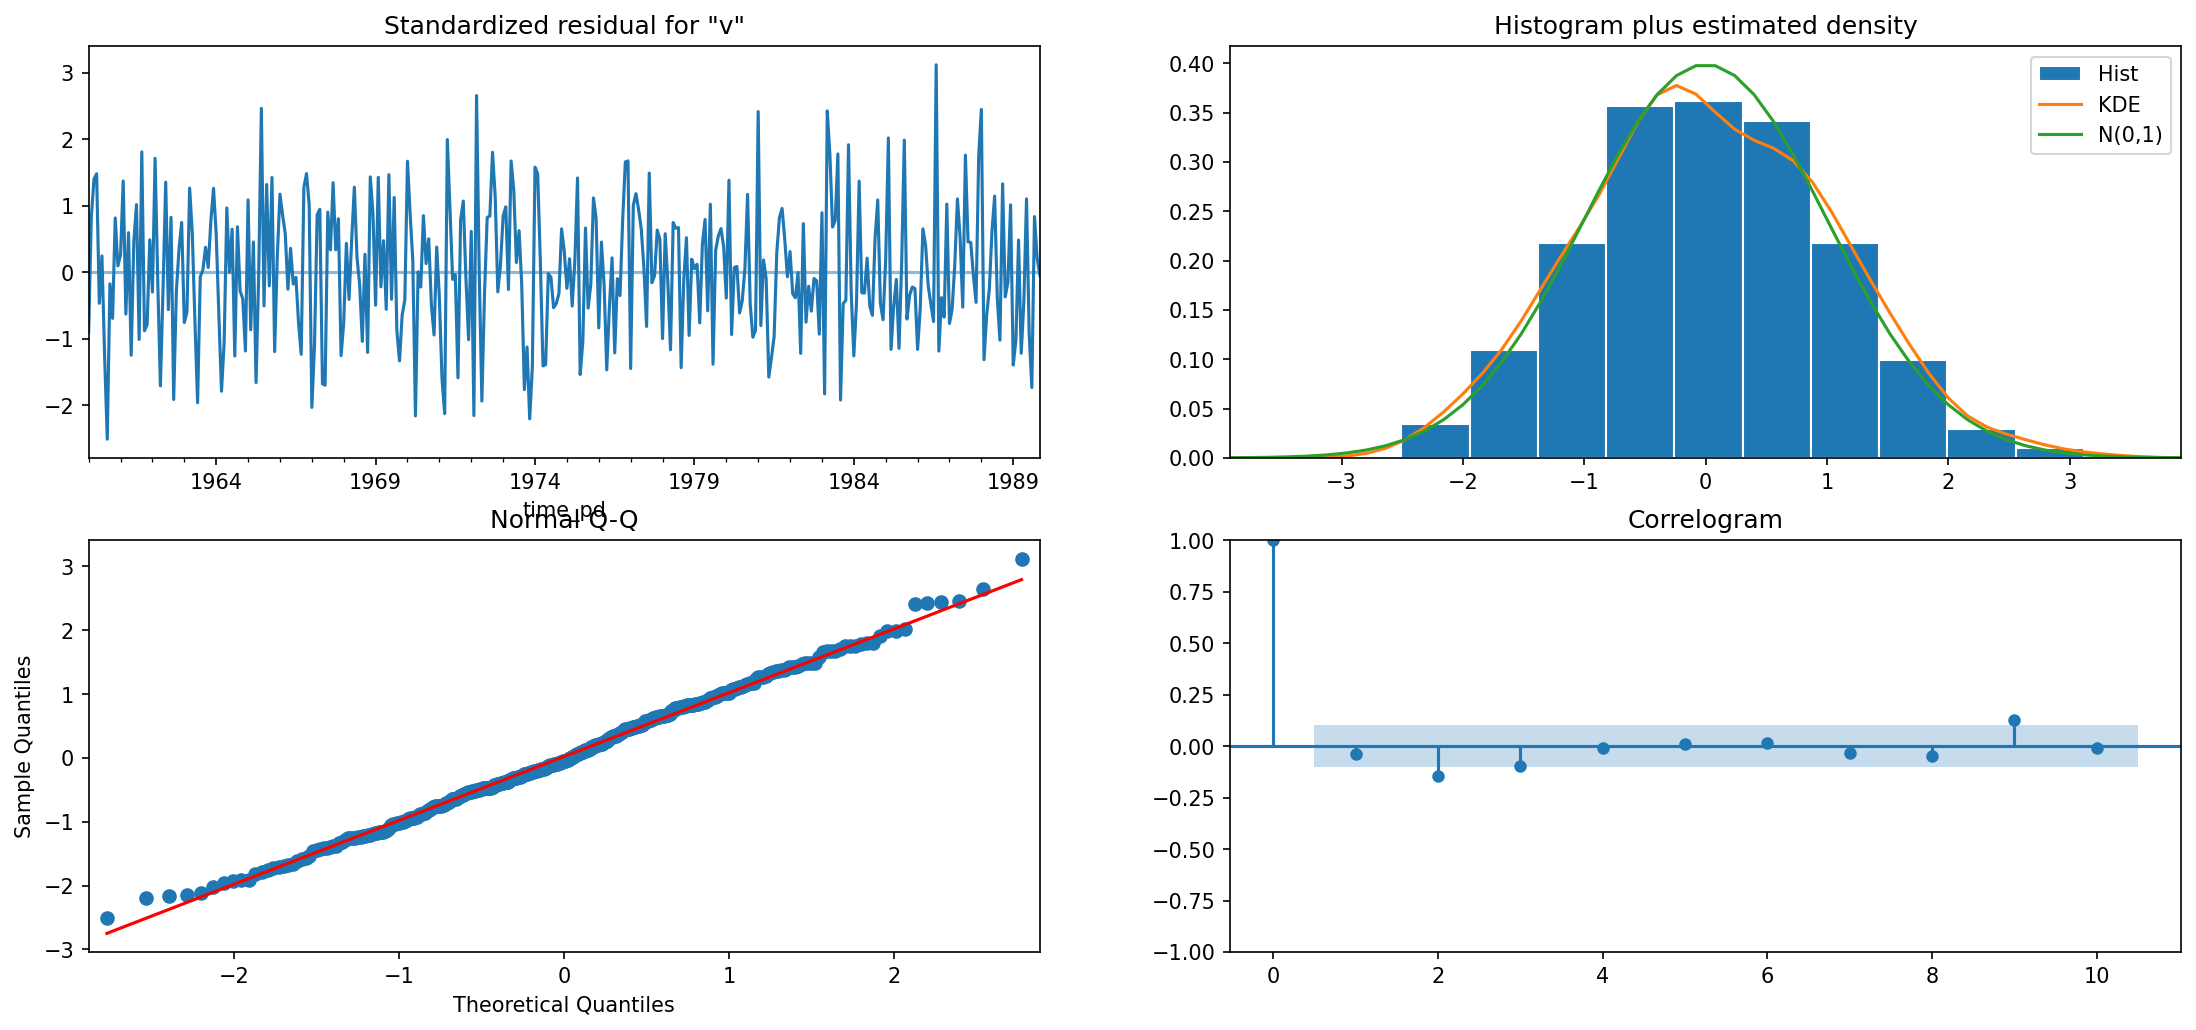

In [13]:
fit_mod.plot_diagnostics(figsize=(18, 8))
plt.show()

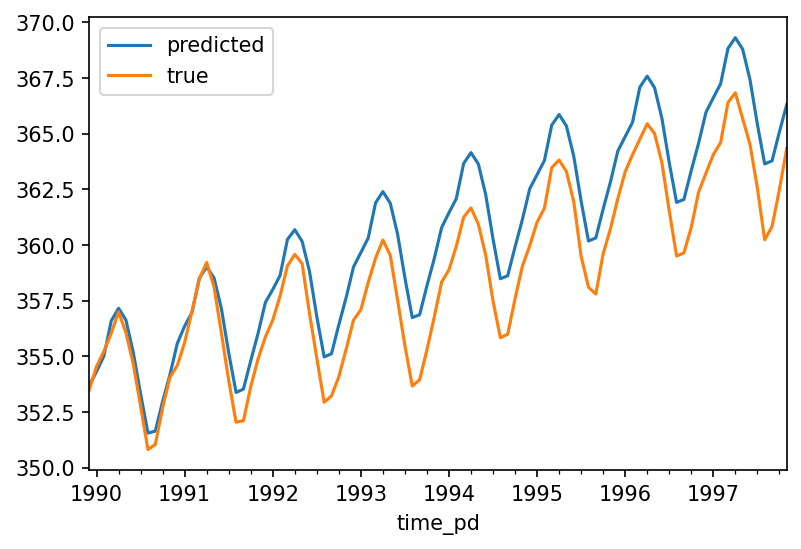

In [14]:
pred = fit_mod.get_forecast(96)
ax = pred.predicted_mean.plot(label = 'predicted')
X_test.value.plot(label='true', ax=ax)
plt.legend()

### ttest on consecutive time stamps

In [15]:
delta = pred.predicted_mean - X_test.value 
ttest_res = pd.DataFrame(delta, columns=['delta'])

In [16]:
def pv_ttest(x):
    return scipy.stats.ttest_1samp(x, popmean=0)[1]

In [17]:
ttest_res['pv'] = ttest_res['delta'].expanding().apply(pv_ttest)
ttest_res

/Users/u19515364/.conda/envs/wotan_test37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


,delta,pv
1989-12,0.196100,NaN
1990-01,-0.231285,9.477073e-01
1990-02,-0.211753,6.145173e-01
1990-03,0.554201,7.090373e-01
1990-04,0.163104,5.544283e-01
...,...,...
1997-07,2.864509,6.401726e-34
1997-08,3.406085,3.215108e-34
1997-09,2.950329,1.064175e-34
1997-10,2.588521,2.963062e-35


In [18]:
ttest_res[ttest_res['pv'] < 0.01].index[0].to_timestamp()

Timestamp('1990-10-01 00:00:00')

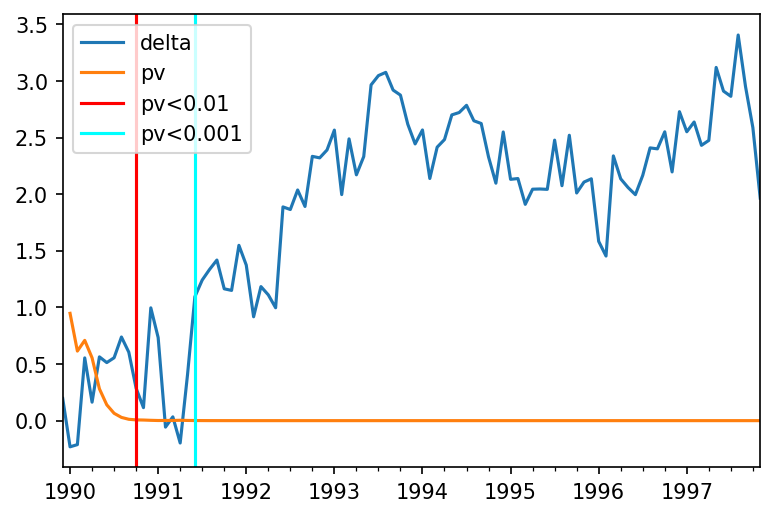

In [19]:
ax = ttest_res.plot()
plt.axvline(ttest_res[ttest_res['pv'] < 0.01].index[0].to_timestamp(), color='red', label='pv<0.01')
plt.axvline(ttest_res[ttest_res['pv'] < 0.001].index[0].to_timestamp(), color='cyan', label='pv<0.001')

plt.legend()

In [20]:
clf = linear_model.BayesianRidge()
clf.fit(np.reshape(np.array(range(12)), (-1, 1)), np.array(pred.predicted_mean[:12]))

BayesianRidge()

### корректрировка прогноза 
прогноз - тренд за 12 прогноза + тренд за 12 факт

In [21]:
edited_trend = clf.predict(np.reshape(np.array(range(96)), (-1, 1)))


In [22]:
clf2 = linear_model.BayesianRidge()
clf2.fit(np.reshape(np.array(range(12)), (-1, 1)), X_test[:12])
true_trend = clf2.predict(np.reshape(np.array(range(96)), (-1, 1)))


/Users/u19515364/.conda/envs/wotan_test37/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


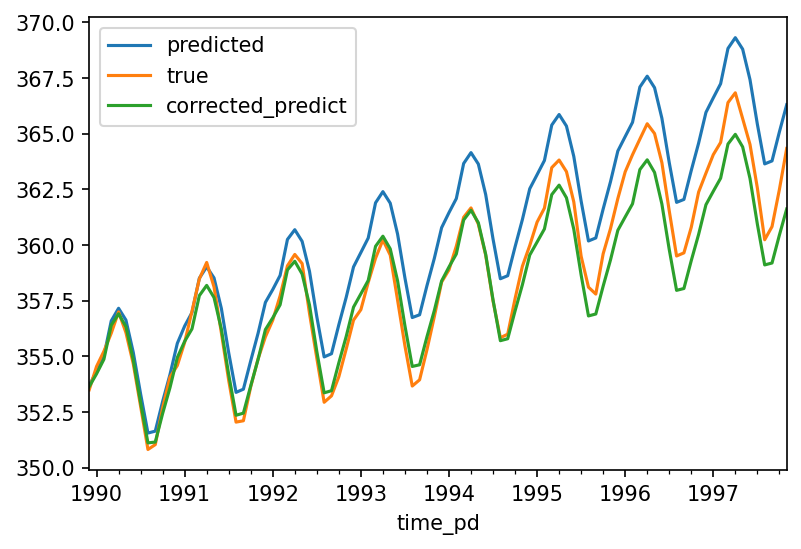

In [23]:
fig, ax = plt.subplots()
pred.predicted_mean.plot(label = 'predicted', ax=ax)
X_test.value.plot(label='true', ax=ax)
pd.DataFrame(pred.predicted_mean- edited_trend+true_trend).rename(columns = {'predicted_mean': 'corrected_predict'}).plot(label='new', ax=ax)

ax.legend()

plt.show()

In [24]:
mape_before_trend_adjust = mean_absolute_percentage_error(X_test.value, pred.predicted_mean)
mape_after = mean_absolute_percentage_error(X_test.value, pred.predicted_mean- edited_trend+true_trend)

print(f'MAPE снижается на с {mape_before_trend_adjust:.4f} до {mape_after:.4f}')

MAPE снижается на с 0.0052 до 0.0022
